In [2]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 29.6 MB/s eta 0:00:00


In [3]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import random
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
class QNetwork(nn.Module):

    def __init__(self, state_shape, h1_nodes, action_space_size, seed):
        """
        state_shape (int): Dimension of each state
        h1_nodes (int): Number of nodes in the first hidden layer
        action_space_size (int): Dimension of each action
        seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        # Define the fully connected layers
        self.fc1 = nn.Linear(state_shape, h1_nodes)  # First layer
        self.fc2 = nn.Linear(h1_nodes, h1_nodes)     # Second layer
        self.fc3 = nn.Linear(h1_nodes, action_space_size)  # Output layer

    def forward(self, state):
        # Define the forward pass with ReLU activations
        x = torch.relu(self.fc1(state))  # Apply ReLU activation after the first layer
        x = torch.relu(self.fc2(x))      # Apply ReLU activation after the second layer
        x = self.fc3(x)                  # Output layer (no activation needed here)
        return x


In [6]:


class ReplayMemory():
    def __init__(self, maxlen, batch_size):
        self.memory = deque([], maxlen=maxlen)  # The deque will store experiences up to a maximum length
        self.batch_size = batch_size

    def append(self, experience):
        """Add an experience to memory"""
        self.memory.append(experience)

    def sample(self):
        """Randomly sample a batch of experiences from memory"""
        # Check if enough experiences are in memory to sample a batch
        if len(self.memory) < self.batch_size:
            return None  # Not enough experiences to sample
        return random.sample(self.memory, self.batch_size)  # Randomly sample a batch

    def __len__(self):
        """Return the current size of memory"""
        return len(self.memory)


In [13]:
class DQAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_shape, action_space_size, seed, h1_nodes=64, learning_rate=5e-4,
                 replay_memory_size=int(1e5), batch_size=64, UPDATE_EVERY=20, LEARN_EVERY=4, GAMMA=0.99, device='cpu'):
        """Initialize an Agent object."""

        self.device = device  # Device (CPU or CUDA)
        self.state_shape = state_shape
        self.action_space_size = action_space_size
        self.seed = random.seed(seed)
        self.GAMMA = GAMMA
        self.UPDATE_EVERY = UPDATE_EVERY
        self.LEARN_EVERY = LEARN_EVERY
        self.h1_nodes = h1_nodes
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.replay_memory_size = replay_memory_size

        # Q-Network
        self.local_dqn = QNetwork(state_shape, h1_nodes, action_space_size, seed).to(self.device)  # Local DQN
        self.target_dqn = QNetwork(state_shape, h1_nodes, action_space_size, seed).to(self.device)  # Target DQN
        self.target_dqn.load_state_dict(self.local_dqn.state_dict())  # Initialize target network with same weights as local
        self.target_dqn.eval()  # Set target network to evaluation mode

        self.optimizer = optim.Adam(self.local_dqn.parameters(), lr=self.learning_rate)

        # Replay memory
        self.memory = ReplayMemory(self.replay_memory_size, self.batch_size)

        # Initialize time steps
        self.l_step = 0
        self.t_step = 0

    def state_to_dqn_input(self, state):
        """Convert state to tensor input for the DQN."""
        return torch.from_numpy(state).float().unsqueeze(0).to(self.device)

    def act(self, state, eps=0.):
        """Returns actions for given state using epsilon-greedy policy."""
        state = self.state_to_dqn_input(state)
        if random.random() > eps:
            # Select the action with the highest Q-value from the local network
            with torch.no_grad():
                action = self.local_dqn(state).argmax(dim=1).item()
        else:
            # Select a random action
            action = random.choice(range(self.action_space_size))
        return action

    def step(self, state, action, reward, next_state, done):
        """Stores experience in memory and learns from it."""
        # Save experience in replay memory
        self.memory.append((state, action, reward, next_state, done))

        # If enough samples are available in memory, get random subset and learn
        self.l_step = (self.l_step + 1) % self.LEARN_EVERY
        if self.l_step == 0 and len(self.memory) > self.batch_size:
            experiences = self.memory.sample()  # Ensure replay memory sampling is done correctly
            self.learn(experiences)

        # Copy local network to target network every UPDATE_EVERY time steps
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:
            self.target_dqn.load_state_dict(self.local_dqn.state_dict())

    def learn(self, experiences):
        """Update the Q-network by minimizing the loss."""
        q_target_list = []
        q_expected_list = []

        # Convert each experience to tensors and calculate Q-values
        for state, action, reward, next_state, done in experiences:
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(self.device)
            action = torch.tensor([action]).long().to(self.device)
            reward = torch.tensor([reward]).float().to(self.device)

            # Compute the target Q-value
            if done:
                q_target = reward
            else:
                with torch.no_grad():
                    q_target = reward + self.GAMMA * self.target_dqn(next_state).max(1)[0].detach()

            # Compute the expected Q-value from the local network
            q_local = self.local_dqn(state).gather(1, action.unsqueeze(1)).squeeze(1)

            q_target_list.append(q_target)
            q_expected_list.append(q_local)

        # Calculate the loss (Mean Squared Error between target and expected Q-values)
        q_target_tensor = torch.cat(q_target_list).to(self.device)
        q_expected_tensor = torch.cat(q_expected_list).to(self.device)
        loss = F.mse_loss(q_expected_tensor, q_target_tensor)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [8]:
import numpy as np
import torch
from tqdm import tqdm

def dqn_train(agent, n_episodes=300, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Train a Deep Q-learning agent."""

    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon

    for i_episode in tqdm(range(1, n_episodes + 1)):
        state = env.reset()[0]          # Get initial state from environment

        score = 0
        for t in range(max_t):
            # Select an action using epsilon-greedy policy
            action = agent.act(state, eps)

            # Apply the selected action
            next_state, reward, done, _, _ = env.step(action)

            # Store the current experience in memory
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward
            if done:
                break

        # Save the most recent score
        scores_window.append(score)
        scores.append(score)

        # Decrease epsilon for exploration-exploitation trade-off
        eps = max(eps_end, eps_decay * eps)

        # Print the average score every 50 episodes
        if i_episode % 50 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')

    # Save the model checkpoint after training
    torch.save(agent.local_dqn.state_dict(), 'checkpoint.pth')

    return scores


In [9]:
env = gym.make('CartPole-v1')
print(env.reset())

print('State shape: ', env.observation_space.shape[0])
print('Number of actions: ', env.action_space.n)

(array([-0.02206585, -0.01774149, -0.01559993, -0.04856776], dtype=float32), {})
State shape:  4
Number of actions:  2


In [14]:
agent = DQAgent(state_shape=env.observation_space.shape[0], action_space_size=env.action_space.n, seed=0)
scores = dqn_train(agent)

 17%|█▋        | 51/300 [00:09<00:38,  6.39it/s]

Episode 50	Average Score: 23.02


 34%|███▎      | 101/300 [00:16<00:28,  6.99it/s]

Episode 100	Average Score: 19.84


 50%|█████     | 150/300 [00:28<00:46,  3.25it/s]

Episode 150	Average Score: 22.73


 67%|██████▋   | 200/300 [00:51<00:44,  2.25it/s]

Episode 200	Average Score: 40.86


 83%|████████▎ | 250/300 [01:38<01:48,  2.18s/it]

Episode 250	Average Score: 81.54


100%|██████████| 300/300 [03:45<00:00,  1.33it/s]

Episode 300	Average Score: 200.04


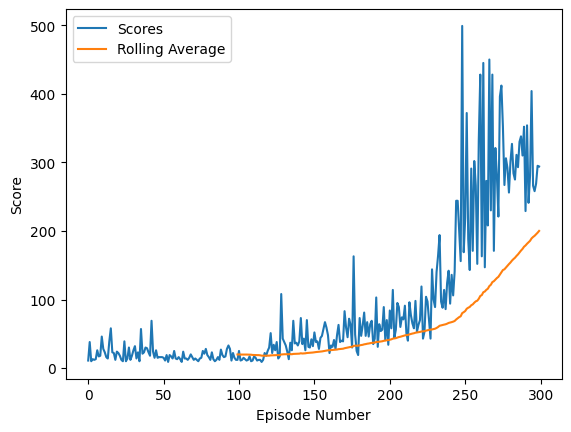

In [15]:
scores = pd.Series(scores, name="scores")
scores.describe()
fig, ax = plt.subplots(1, 1)
_ = scores.plot(ax=ax, label="Scores")
_ = (scores.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("Score")